In [1]:
import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt
import pandas as pd
from glasflow import RealNVP, CouplingNSF

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
import os
import json
import glob



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from .utils import PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
from river.models.utils import *
from river.data.utils import *

import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
from river.data.dataset import DatasetSVDStrainFDFromSVDWFonGPU, DatasetSVDStrainFDFromSVDWFonGPUBatch
from river.data.dataset import DatasetConvStrainFDFromSVDWFonGPU, DatasetConvStrainFDFromSVDWFonGPUBatch
#import river.data.utils as datautils
from river.data.utils import *
from river.data.reparameterize import *

from river.models import embedding
from river.models.utils import *
#from river.models.embedding.pca import project_strain_data_FDAPhi
from river.models.embedding.conv import EmbeddingConv1D, EmbeddingConv2D
from river.models.embedding.mlp import EmbeddingMLP1D
from river.models.inference.cnf import GlasflowEmbdding

# Make test data

In [3]:
source_type = 'BNS'
detector_names = ['H1', 'L1', 'V1'] 
duration = 32
f_low = 50
f_high = 1024

f_ref = 20
sampling_frequency = 2048
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'bilby_default' #'zero_noise' bilby_default
use_sealgw_detector = True

Vhfile="/home/qian.hu/mlpe/river/test/outputs/Vh_50Hz1024Hz32s.pickle"

data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
            f_high=f_high)

01:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [4]:
validfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/valid'
trainfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/train'
#noisefolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin/noise/design'

valid_filenames = glob.glob(f"{validfolder}/batch*/*.h5")
train_filenames = glob.glob(f"{trainfolder}/batch*/*.h5")

add_noise = True
do_reparameterize = True
fix_extrinsic = False

device='cuda:1'
dataset_valid = DatasetSVDStrainFDFromSVDWFonGPU(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=fix_extrinsic, add_noise=add_noise,reparameterize=do_reparameterize,
                                                device=device)
#dataset_valid = DatasetConvStrainFDFromSVDWFonGPU(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
#                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=fix_extrinsic, add_noise=add_noise,reparameterize=do_reparameterize)

#dataset_train = DatasetSVDStrainFDFromSVDWFonGPU(train_filenames[:1], PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
#                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=True)

#dataset_train = DatasetSVDStrainFDFromSVDWFonGPUBatch(train_filenames[:1], PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
#                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=True, add_noise=add_noise,reparameterize=do_reparameterize)



In [5]:
dataset_valid = DatasetSVDStrainFDFromSVDWFonGPU(train_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, fix_extrinsic=fix_extrinsic, add_noise=add_noise,reparameterize=do_reparameterize)


In [12]:
!nvidia-smi

Thu May  9 01:47:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:01:00.0 Off |                  N/A |
| 44%   67C    P2            311W /  320W |    4559MiB /  10240MiB |     99%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
detector_names = config_datagenerator['detector_names']

Ntest = 2
injection_parameters_test = generate_BNS_injection_parameters(Nsample = 2*Ntest, **config_datagenerator)
data_generator_test = DataGeneratorBilbyFD(**config_datagenerator)


00:54 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [6]:
data_generator_test.inject_signals(injection_parameters_test, 2*Ntest, Ntest)
data_generator_test.numpy_starins()

Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 25.0% done


In [7]:
data_generator_test.data['strains']['H1'].shape

(2, 321281)

In [8]:
x = project_data(data_generator_test, ipca_gen, detector_names)

data_dict = {}
data_dict['x'] = x.numpy()
data_dict['injection_parameters'] = data_generator_test.data['injection_parameters']



In [26]:
dataset_test = DatasetXFromPreCalSVDData(precaldata_list=[data_dict],  parameter_names=config_datagenerator['context_parameter_names'])


def read_in_x(filename_list, Nsample=1e20):
    x_list = []
    for filename in filename_list:
        if len(x_list)*200>Nsample:
            break
        x_list.append(load_dict_from_hdf5(filename))
    return x_list

valid_precaldata_filelist = glob.glob(f"{config['precaldata_parameters']['valid']['folder']}/batch*/*.h5")
valid_precaldata_list = read_in_x(valid_precaldata_filelist, Nsample=3)
dataset_valid = DatasetXFromPreCalSVDData(precaldata_list=valid_precaldata_list,  parameter_names=config_datagenerator['context_parameter_names'])



In [9]:
len(dataset_test)

2

In [10]:
#batch_size = 1
#test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

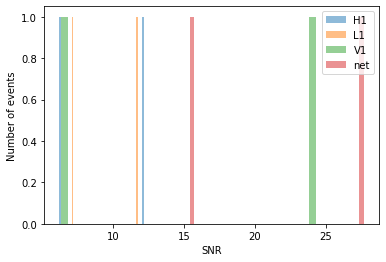

In [9]:

for key, values in data_generator_test.data['SNRs'].items():
    _ = plt.hist(values, label=key, alpha=0.5, bins=40)
_ = plt.hist((data_generator_test.data['SNRs']['H1']**2 + data_generator_test.data['SNRs']['L1']**2 + data_generator_test.data['SNRs']['V1']**2 )**0.5,
                label='net', alpha=0.5, bins=40)
plt.legend()
plt.xlabel('SNR')
plt.ylabel('Number of events')
plt.show()

In [10]:
(data_generator_test.data['SNRs']['H1']**2 + data_generator_test.data['SNRs']['L1']**2 + data_generator_test.data['SNRs']['V1']**2 )**0.5

array([15.39624868, 27.69616012])

# Load model

In [14]:
#config_path = '/home/qian.hu/mlpe/river/scripts/trained_models/BNS50102432_SVDRealImag_Conv1D_8M_17D_3'
#config_path = '/home/qian.hu/mlpe/river/scripts/trained_models/BNS50102432_ConvRealImag_Conv1D_8M_17D'
#config_path = '/home/qian.hu/mlpe/river/scripts/trained_models/BNS50102432_RealImag_Conv1D_8M_12D_nn'
config_path = '/home/qian.hu/mlpe/river/scripts/trained_models/BNS50102432_SVDViT_testdim1'
with open(f"{config_path}/config.json", 'r') as f:
        config_dict = json.load(f)

device='cuda:1'
model = GlasflowEmbdding(config_dict).to(device)


In [15]:
ckpt_dir = config_dict['ckpt_dir']
ckpt_path = f'{ckpt_dir}/checkpoint.pickle'

In [16]:

checkpoint = torch.load(ckpt_path, map_location=device)
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict']) 

print(f'Loaded states from {ckpt_path}, epoch={start_epoch}.')

Loaded states from trained_models/BNS50102432_SVDViT_testdim1/checkpoint.pickle, epoch=242.


In [17]:
train_losses_vit = np.loadtxt('/home/qian.hu/mlpe/river/scripts/trained_models/BNS50102432_SVDViT_testdim1/train_losses.txt')
valid_losses_vit = np.loadtxt('/home/qian.hu/mlpe/river/scripts/trained_models/BNS50102432_SVDViT_testdim1/valid_losses.txt')



train_losses_cnn = np.loadtxt('/home/qian.hu/mlpe/river/scripts/trained_models/BNS50102432_SVDConv_2/train_losses.txt')
valid_losses_cnn = np.loadtxt('/home/qian.hu/mlpe/river/scripts/trained_models/BNS50102432_SVDConv_2/valid_losses.txt')




Text(0.5, 0, 'epoch')

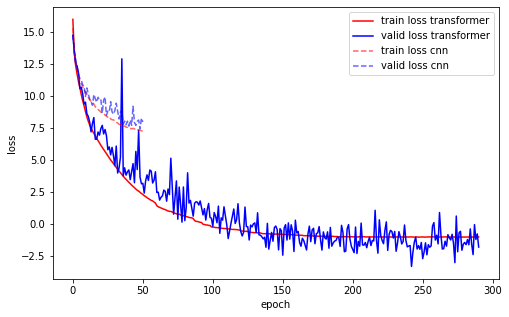

In [8]:
plt.figure(figsize=(8,5))
plt.plot(train_losses_vit, label='train loss transformer', color='r')
plt.plot(valid_losses_vit, label='valid loss transformer', color='b')

plt.plot(train_losses_cnn, label='train loss cnn', color='r', linestyle='--', alpha=0.6)
plt.plot(valid_losses_cnn, label='valid loss cnn', color='b', linestyle='--', alpha=0.6)

plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')

In [18]:
def mysample_GlasNSFWarpper(model, dataset, parameter_names=None, device='cpu', Nsample=5000, max_event=1e3):
    model.eval()
    loss_list = []
    sample_list = []
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    injection_parameters_list = []
    with torch.no_grad():
        i = 0
        for theta, x in dataloader:
            theta = theta.to(device)
            x = x.to(device)
            
            if type(dataset) in [DatasetSVDStrainFDFromSVDWFonGPUBatch, DatasetConvStrainFDFromSVDWFonGPUBatch]:
                #print('w3')
                theta = theta.view(dataset.minibatch_size, theta.shape[-1])
                x = x.view(dataset.minibatch_size, x.shape[-2], x.shape[-1])
            
            
            lenx = x.shape[-1]
            lentheta = theta.shape[-1]
            loss = -model.log_prob(theta, x=x).mean()
            samples = model.sample(Nsample, x=x)
            
            inj_para = {}
            for j, paraname in enumerate(parameter_names):
                inj_para[paraname] = inverse_reparameterize(theta[0][j].cpu().numpy(), paraname)
                
            loss_list.append(loss.detach().cpu())
            sample_list.append(samples.cpu().numpy())
            injection_parameters_list.append(inj_para)
            i+=1
            if i>=max_event:
                break
            
    samples = np.array(sample_list)
    samples = torch.from_numpy(samples)

    return samples.movedim(1,2), loss_list, injection_parameters_list


In [19]:
if fix_extrinsic:
    parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
else:
    parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase', 
                   'ra', 'dec', 'psi', 'geocent_time', 'luminosity_distance']
    
max_event = 100
Nsample = 5000
sample_list, loss_list, injection_parameters_list =  mysample_GlasNSFWarpper(model, dataset_valid, parameter_names=parameter_names,
                                                                             device=device, Nsample=Nsample, max_event=max_event)



/home/qian.hu/mlpe/river/river/data/dataset.py:190: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  theta = torch.tensor(theta_array, dtype=torch.float32).to(self.device).T


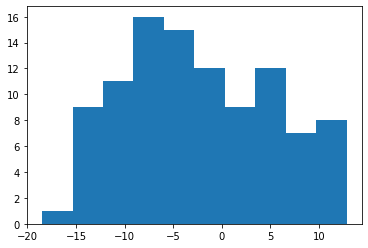

In [20]:
_ = plt.hist(loss_list)

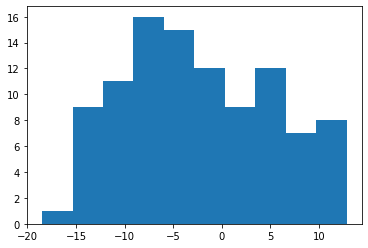

In [21]:
_ = plt.hist(loss_list)

In [22]:
def make_results(sample_list, parameter_names, injection_parameters_list=None):
    Nresult = len(sample_list)

    result_list = []
    for i in range(Nresult):
        result = bilby.gw.result.CompactBinaryCoalescenceResult()
        injection_parameters = {}
        posterior_dict = {}
        search_parameter_keys = []
        parameter_labels_with_unit = []
        for j,paraname in enumerate(parameter_names):
            '''
            if paraname=='chirp_mass':
                s = np.array(sample_list[i][j].cpu())
                s = 10**inverse_reparameterize(s, 'log10_chirp_mass')
                posterior_dict[paraname] = s
            else:
                posterior_dict[paraname] = inverse_reparameterize(np.array(sample_list[i][j].cpu()), paraname)
            '''
            posterior_dict[paraname] = inverse_reparameterize(np.array(sample_list[i][j].cpu()), paraname)
            search_parameter_keys.append(paraname)
            parameter_labels_with_unit.append(paraname)
        
        result.posterior = pd.DataFrame.from_dict(posterior_dict)
        result.injection_parameters = injection_parameters_list[i]
        
        #result.injection_parameters['chirp_mass'] = \
        #    reparameterize(torch.log10(inverse_reparameterize(result.injection_parameters['chirp_mass'], 'chirp_mass')), 'log10_chirp_mass')
        
        
        result.search_parameter_keys = search_parameter_keys
        result.parameter_labels_with_unit = parameter_labels_with_unit
        result_list.append(result)
    
    return result_list

In [23]:
#result_list = make_results(sample_list, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY)
result_list = make_results(sample_list, parameter_names, injection_parameters_list)

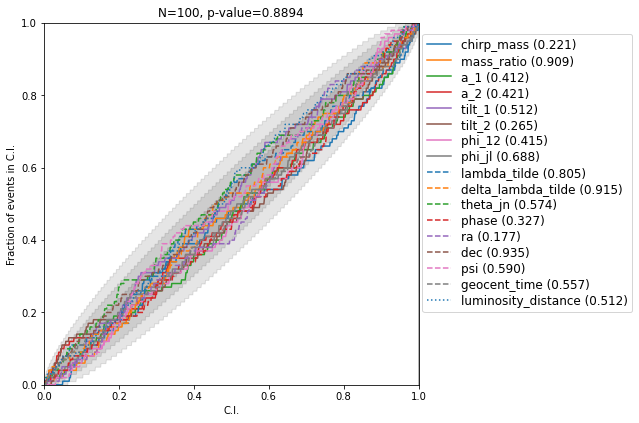

In [24]:
#fig = bilby.core.result.make_pp_plot(result_list, filename=None, save=False, confidence_interval=[0.68, 0.95, 0.997])
fig = make_pp_plot(result_list, filename = f"{config_path}/pp_plot.png", save=False, confidence_interval=[0.68, 0.95, 0.997])


In [57]:
look_index = np.argmin(loss_list)
#look_index = np.argmax(loss_list)
#look_index = 1
result = result_list[look_index]
loss_list[look_index]

tensor(-18.4902)

In [58]:
def remove_invalid_index(posterior):        
    
    valid_mask_ra = (posterior['ra']>=0) * (posterior['ra']<np.pi*2)
    valid_mask_dec = (posterior['dec']>=-np.pi/2) * (posterior['dec']<=np.pi/2)
    valid_mask_spin = (posterior['a_1']>=0) * (posterior['a_1']<1) * (posterior['a_2']>=0) * (posterior['a_2']<1)
    
    
    valid_mask_all = valid_mask_ra * valid_mask_dec * valid_mask_spin
    
    new_post = posterior[valid_mask_all]
    print(f"Removed {len(posterior) - len(new_post)} invalid posterior samples")
    return new_post

In [59]:
result.posterior = remove_invalid_index(result.posterior)
result.posterior = bilby.gw.conversion.generate_all_bns_parameters(result.posterior)

Removed 16 invalid posterior samples


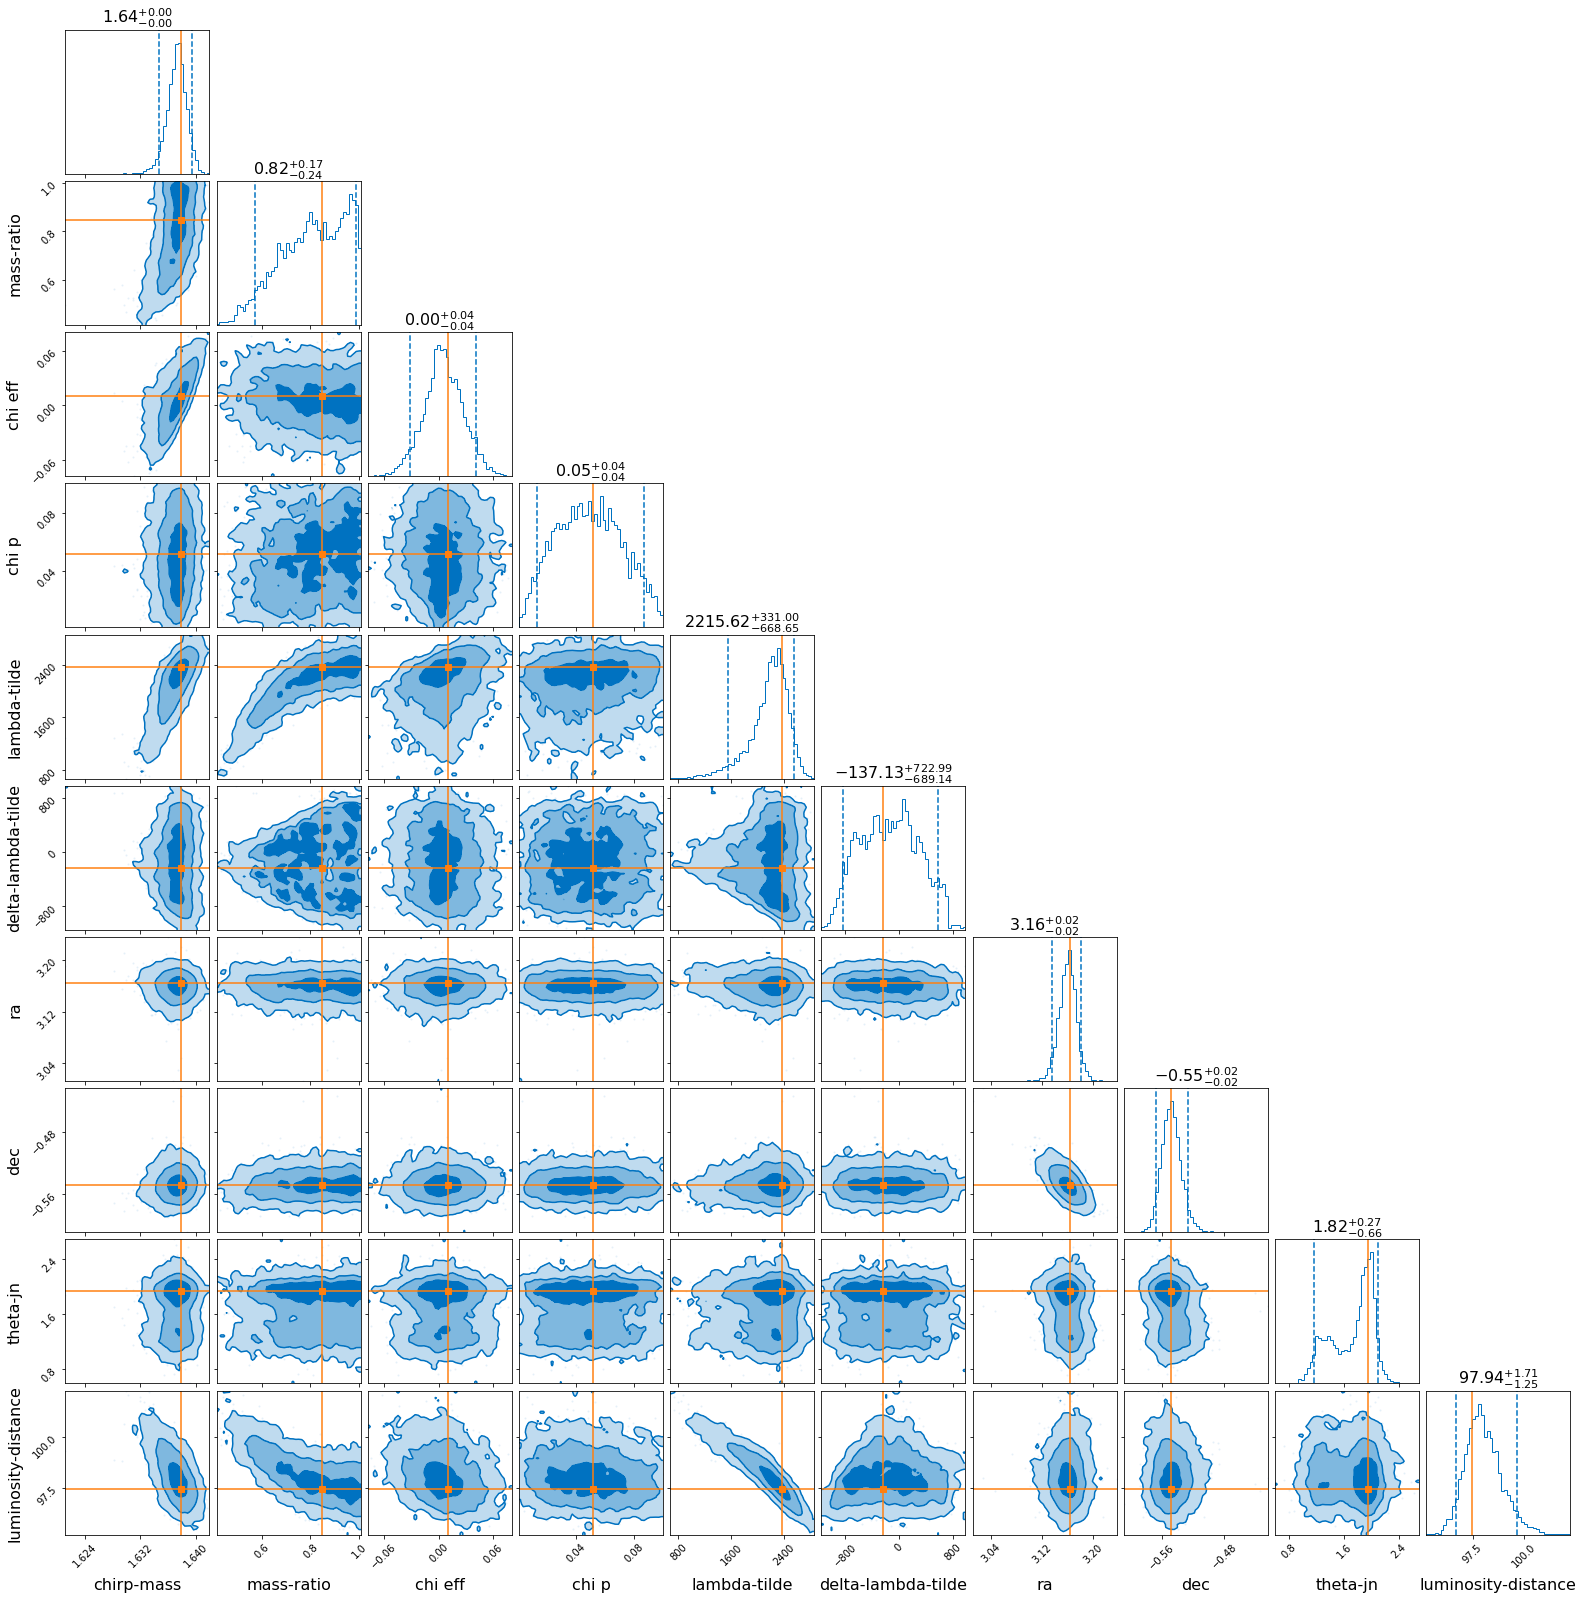

In [60]:
#injdict = {}
#for i,paraname in enumerate(config_dict['data_generator_parameters']['context_parameter_names']):
#for i,paraname in enumerate(parameter_names):
#    injdict[paraname] = dataset_valid[0][0][i].cpu()

injdict = bilby.gw.conversion.generate_all_bns_parameters(result.injection_parameters)
#result.injection_parameters = injdict
filename =  f"{config_path}/corner{look_index}.png"


plot_params = {}
plot_keys = ['chirp_mass', 'mass_ratio', 'chi_eff', 'chi_p', 'lambda_tilde', 'delta_lambda_tilde', 
            'ra', 'dec', 'theta_jn', 'luminosity_distance']
for key in plot_keys:
    plot_params[key] = injdict[key]
    result.parameter_labels = key
#plot_params = result.injection_parameters
fig = result.plot_corner(parameters=plot_params, save=False, filename = filename, quantiles=[0.05,0.95])





In [18]:
result_prior = bilby.core.result.read_in_result('/home/qian.hu/mlpe/river/scripts/outputs/prior_samples.pkl')
results = [result, result_prior]


/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


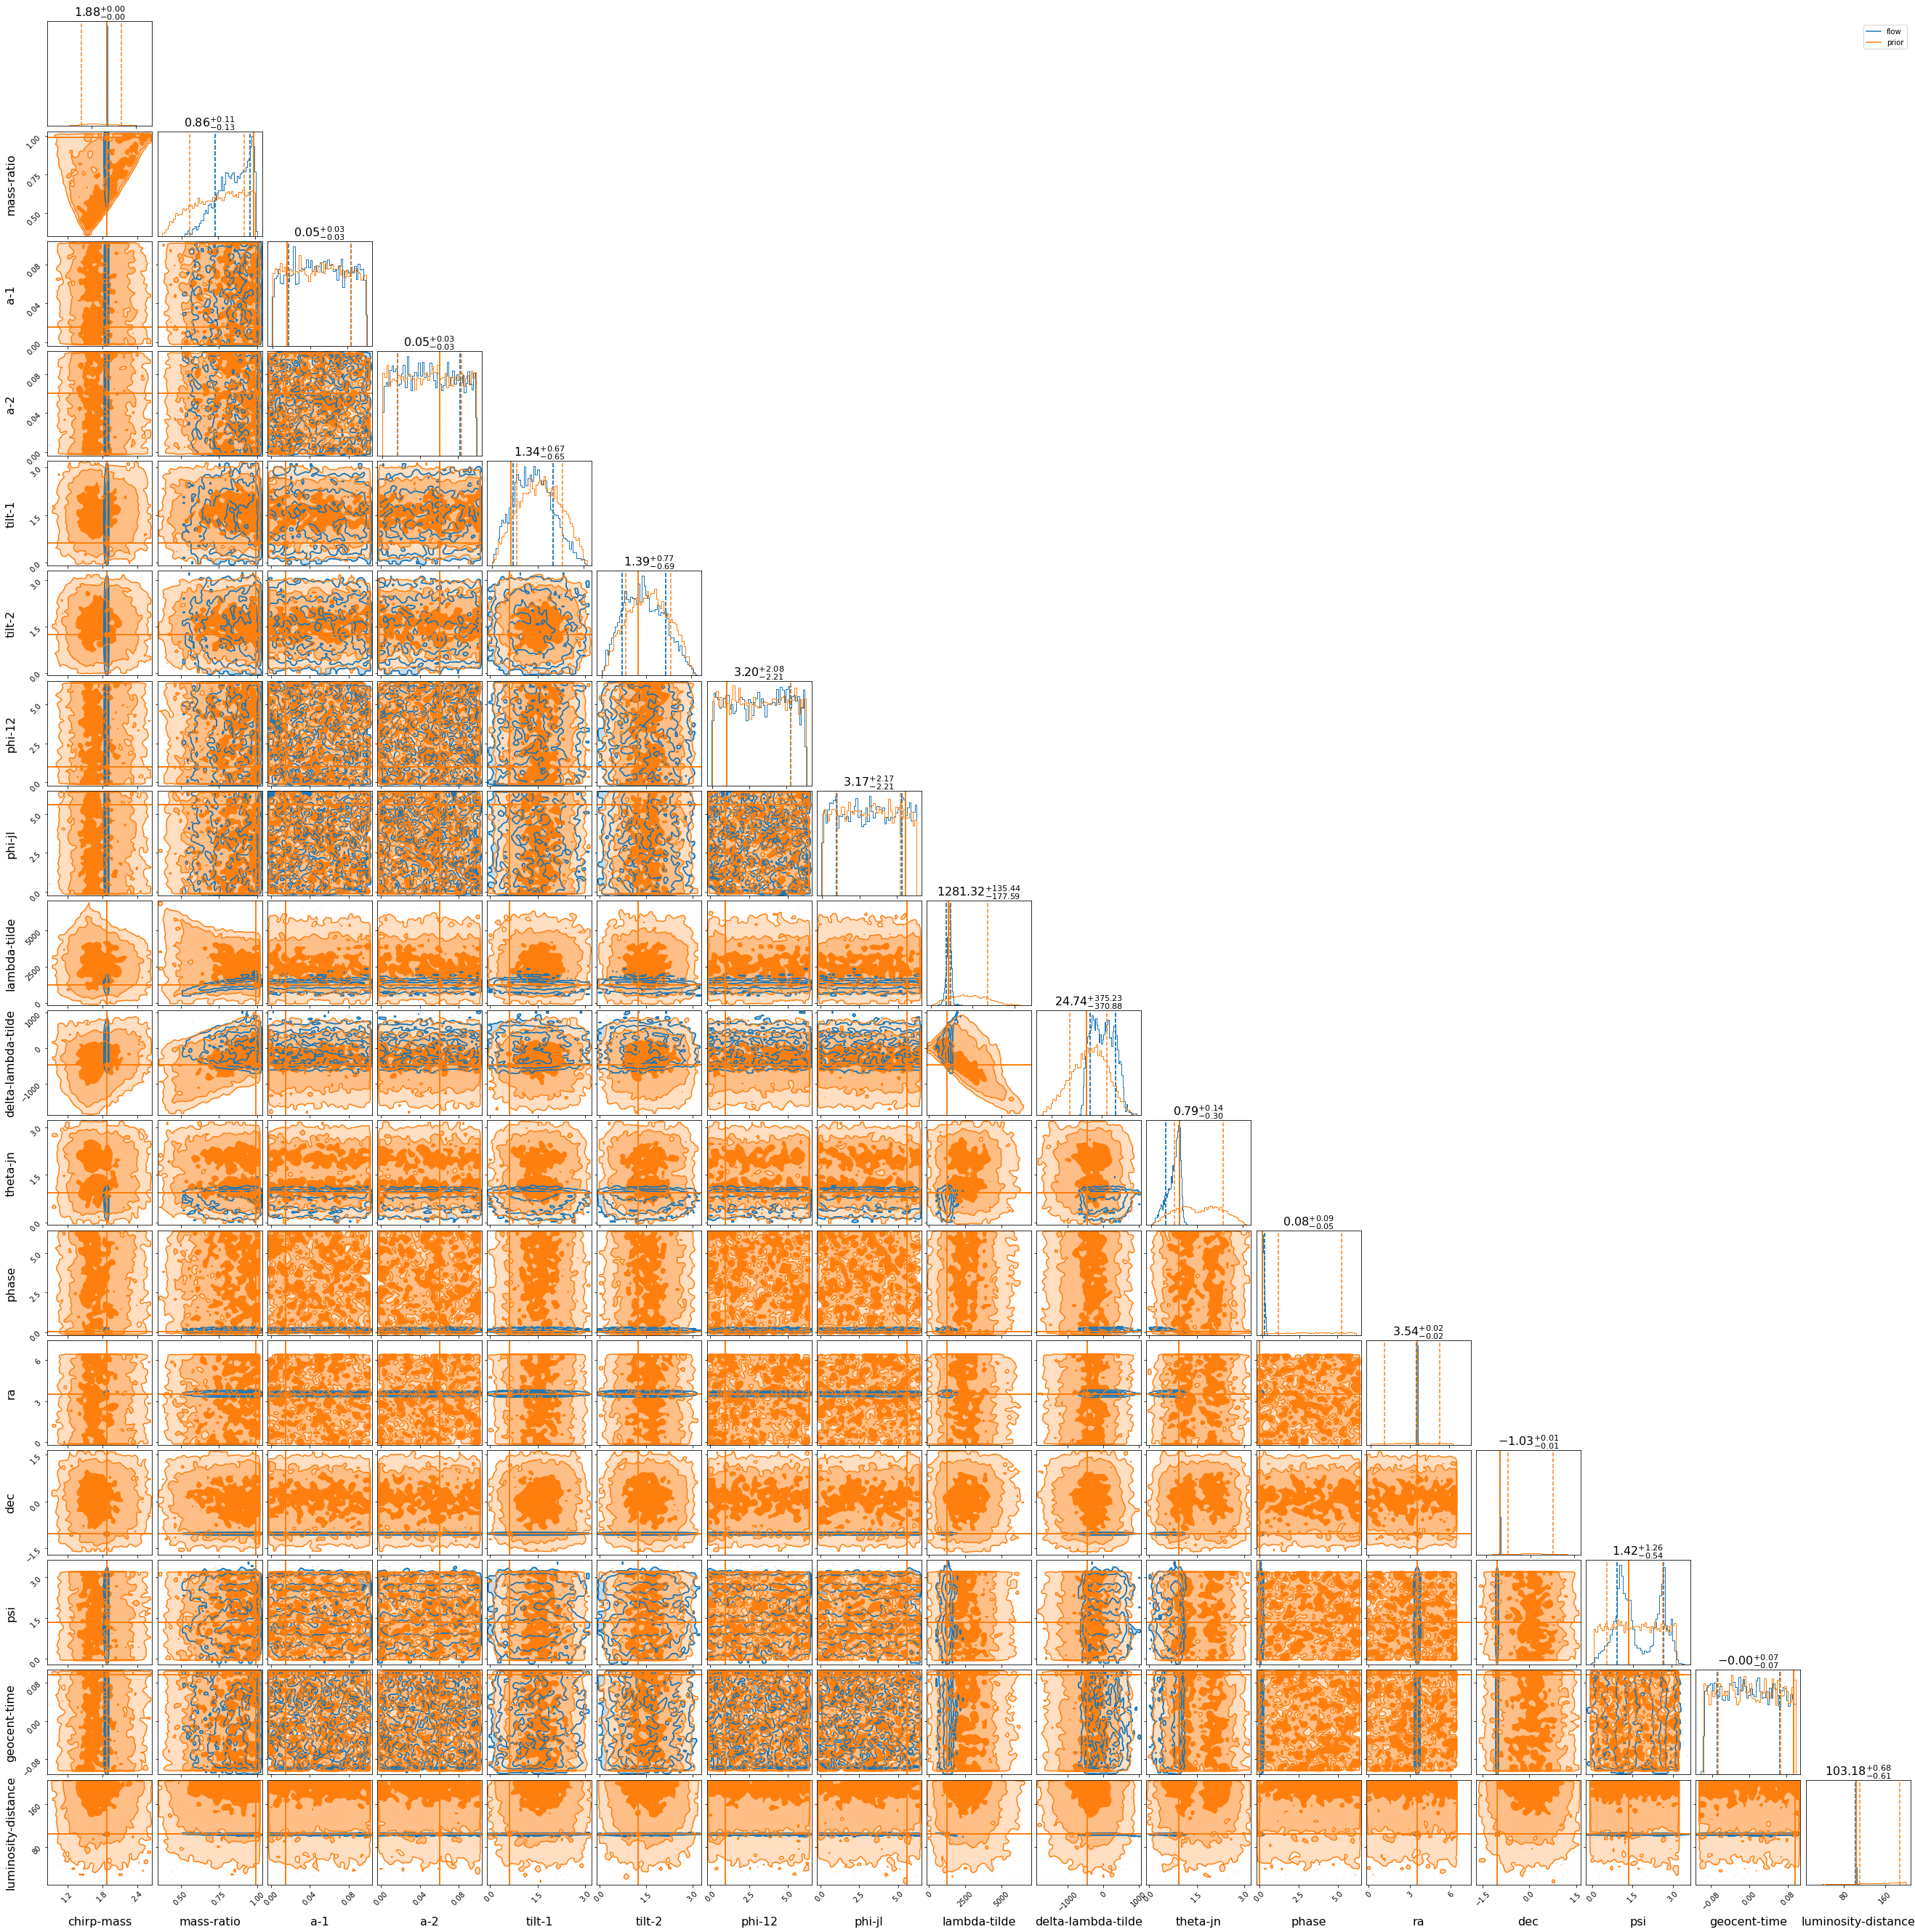

In [19]:
fig = bilby.core.result.plot_multiple(results, parameters=plot_params, filename=None, labels=['flow', 'prior'], colours=None, save=False, evidences=False, corner_labels=None, linestyles=None)



# compare skymap

In [67]:
import bilby
import numpy as np 
import time
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing
from functools import partial
from matplotlib.pyplot import MultipleLocator
from bilby.gw import conversion
from scipy.optimize import leastsq
import json
from pycbc.filter import matched_filter,matched_filter_core
from pycbc.types.timeseries import TimeSeries
from pycbc.types.frequencyseries import FrequencySeries
from lal import LIGOTimeGPS

import sealgw
from sealgw import seal
import sealgw.calculation as sealcal
import sealgw.simulation as sealsim

In [68]:
!ls ~/SealGW/share/examples/example_outputs

bimodal_fitting_custom.png	     linear_fitting.png
bimodal_fitting.png		     sealconfig_bilby_lhv_BBH.txt
catalog_statistics_short.txt	     sealconfig_bilby_lhv_BNS.txt
catalog_statistics.txt		     sealconfig_bilby_lhv_NSBH.txt
config_ew0s_lhv.txt		     sealconfig_O2_lhv_BNS.txt
config_ew10s_lhv.txt		     skymap_LHVew_0s.png
config_ew20s_lhv.txt		     skymap_LHVew_10s.png
config_ew30s_lhv.txt		     skymap_LHVew_20s.png
config_ew5s_lhv.txt		     skymap_LHVew_30s.png
config_multiple_saving_example.json  skymap_LHVew_5s.png
ew_example_skymap.gif		     skymap_SPIIR_trigger.pdf
linear_fitting_custom.png	     skymap_SPIIR_trigger_UNIQ.fits


In [69]:
seal_O4 = seal.Seal('/home/qian.hu/SealGW/share/examples/example_outputs/sealconfig_bilby_lhv_BNS.txt', source_type='BNS') 




In [70]:
test_result = result_list[look_index]

In [71]:
injection_parameters = bilby.gw.conversion.generate_all_bns_parameters(test_result.injection_parameters)

duration = 320. # 16
sampling_frequency = 2048


waveform_arguments = dict(waveform_approximant='IMRPhenomPv2_NRTidal', minimum_frequency=50.)


waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    waveform_arguments=waveform_arguments)

det_names = ['H1', 'L1', 'V1']

ifos = bilby.gw.detector.InterferometerList(det_names)

#psd_files = ['example_inputs/H1_psd.txt','example_inputs/L1_psd.txt', 'example_inputs/V1_psd.txt']
# if your want to use your own PSD
#for i in range(len(ifos)):
#    det = ifos[i]
#    psd_file = psd_files[i]
#    psd = bilby.gw.detector.PowerSpectralDensity(psd_file=psd_file)
#    det.power_spectral_density = psd 

ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - duration + 1)

ifos.inject_signal(waveform_generator=waveform_generator,
                parameters=injection_parameters)

02:19 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
02:19 bilby INFO    : Injected signal in H1:
02:19 bilby INFO    :   optimal SNR = 14.37
02:19 bilby INFO    :   matched filter SNR = 12.66-0.32j
02:19 bilby INFO    :   chirp_mass = 1.6379455355572365
02:19 bilby INFO    :   mass_ratio = 0.8484030443775937
02:19 bilby INFO    :   a_1 = 0.02518877110461698
02:19 bilby INFO    :   a_2 = 0.06450118284006673
02:19 bilby INFO    :   tilt_1 = 1.3442839652029823
02:19 bilby INFO    :   tilt_2 = 1.311171995407518
02:19 bilby INFO    :   phi_12 = 0.6935446726491636
02:19 bilby INFO    :   phi_jl = 2.758462390676553
02:19 bilby INFO    :   lambda_tilde = 2359.216864465457
02:19 bilby INFO    :   delta_lambda_tilde = -233.35780518661215
02:19 bilby INFO    :   theta_jn = 1.9424320406402282
02:19 bilb

02:19 bilby INFO    :   mass_1_source = 2.000722040492772
02:19 bilby INFO    :   mass_2_source = 1.697418670107419
02:19 bilby INFO    :   chirp_mass_source = 1.6032038694606459
02:19 bilby INFO    :   total_mass_source = 3.6981407106001907


[{'plus': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         1.32293507e-27+5.30967407e-28j, 1.32207275e-27+5.30614001e-28j,
         0.00000000e+00+0.00000000e+00j]),
  'cross': array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -3.14061164e-28+8.86330367e-28j, -3.13851352e-28+8.85752363e-28j,
          0.00000000e+00-0.00000000e+00j])},
 {'plus': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         1.32293507e-27+5.30967407e-28j, 1.32207275e-27+5.30614001e-28j,
         0.00000000e+00+0.00000000e+00j]),
  'cross': array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -3.14061164e-28+8.86330367e-28j, -3.13851352e-28+8.85752363e-28j,
          0.00000000e+00-0.00000000e+00j])},
 {'plus': ar

In [72]:
snr_list, sigma_list = sealsim.generating_data.snr_generator(ifos, waveform_generator, injection_parameters)
print('injection tc: ', injection_parameters['geocent_time'])
max_snr_sq = 0

det_id = 0
for snr in snr_list:
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    max_snr_sq += abs(snrp)**2
    time = snr.sample_times[peak]
    print('Max snr time: {}, SNR = {}'.format( time , abs(snrp)) )
    
    det_id +=1

print('Max network SNR: ', max_snr_sq**0.5)

injection tc:  -0.05999569044584132
Max snr time: -0.03997615874999383, SNR = 12.625810056264683
Max snr time: -0.03899959624999383, SNR = 15.306133964228948
Max snr time: -0.05853084624999383, SNR = 7.463144867965792
Max network SNR:  21.198758167120108


In [73]:
nthread = 4

det_names = ['H1', 'L1', 'V1']

# Rearrange some variables: snr_arrays, time_arrays are 1-D array
time_arrays = np.array([])
snr_arrays = np.array([])
ntimes_array = np.array([])
for snr in snr_list:
    snr_arrays = np.append(snr_arrays, snr.data)
    time_arrays = np.append(time_arrays, snr.sample_times.data)
    ntimes_array = np.append(ntimes_array, len(snr.sample_times.data))

max_snr = max_snr_sq**0.5
sigma_array = np.array(sigma_list)

start_time = injection_parameters['geocent_time'] - 0.01
end_time = injection_parameters['geocent_time'] + 0.01


prob_skymap, timecost = seal_O4.localize( det_names, time_arrays, snr_arrays, max_snr, sigma_array, ntimes_array, start_time, end_time,
         nthread,  timecost=True, interp_factor=10, use_timediff=False)

print("Timecost (s): ", timecost)

Timecost (s):  0.8719863891601562


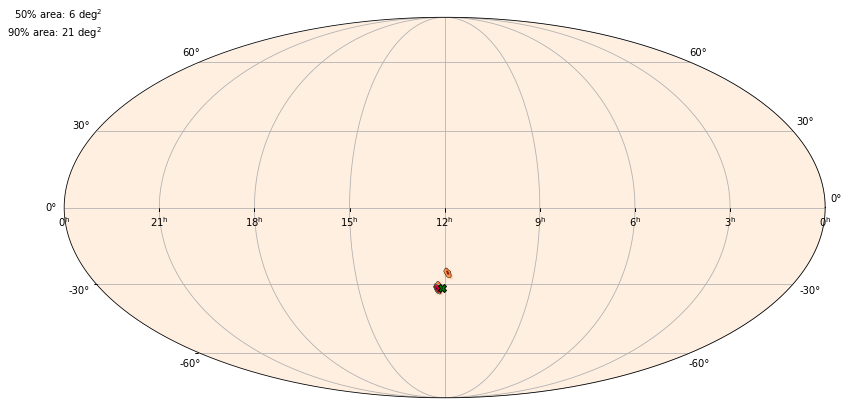

In [74]:
true_ra = injection_parameters['ra']
true_dec = injection_parameters['dec']

fig = sealcal.localization.plot_skymap(prob_skymap, true_ra = true_ra, true_dec = true_dec)

02:19 bilby INFO    : Reading samples for skymap
02:19 bilby INFO    : Initialising skymap class


02:42 bilby INFO    : Pickling skymap to /home/qian.hu/mlpe/river/scripts/no_label_skypost.obj
02:42 bilby INFO    : Making skymap



adaptive refinement round 0 of 8 ...
adaptive refinement round 1 of 8 ...
adaptive refinement round 2 of 8 ...
adaptive refinement round 3 of 8 ...
adaptive refinement round 4 of 8 ...
adaptive refinement round 5 of 8 ...
adaptive refinement round 6 of 8 ...
adaptive refinement round 7 of 8 ...
adaptive refinement round 8 of 8 ...
evaluating distance layers ...


02:43 bilby INFO    : Saving skymap fits-file to /home/qian.hu/mlpe/river/scripts/no_label_skymap.fits
02:44 bilby INFO    : Generating 2D projected skymap to /home/qian.hu/mlpe/river/scripts/no_label_skymap.png


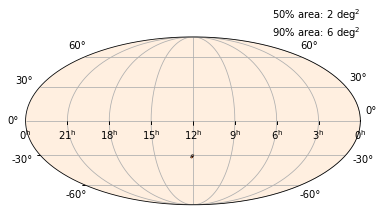

In [75]:
test_result.plot_skymap()